## Separación en train y validación

In [1]:

import pandas as pd

# Volver a cargar los CSV originales y aumentados
augmented_df = pd.read_csv("C:/Users/34629/TFG/dataset_GAN_mio.csv")
original_df = pd.read_csv("C:/Users/34629/TFG/single_label_dataset_without_H_no_O.csv")

# Identificar las clases disponibles
classes = ['N', 'D', 'G', 'C', 'A', 'M']

# Añadir una columna con la clase dominante
def get_class_label(row):
    for c in classes:
        if row[c] == 1:
            return c
    return None

# Aplicar a ambos datasets
augmented_df['class_label'] = augmented_df.apply(get_class_label, axis=1)
original_df['class_label'] = original_df.apply(get_class_label, axis=1)

# Identificar imágenes originales dentro del dataset aumentado
original_paths = set(original_df['Image_Path'])
augmented_df['is_original'] = augmented_df['Image_Path'].isin(original_paths)

# Seleccionar 10% por clase para validación (solo de imágenes originales)
val_df = (
    augmented_df[augmented_df['is_original']]
    .groupby('class_label', group_keys=False)
    .apply(lambda x: x.sample(frac=0.10, random_state=42))
)

# El resto será entrenamiento: originales restantes + aumentadas no originales
train_df = augmented_df[~augmented_df['Image_Path'].isin(val_df['Image_Path'])]

# Guardar CSVs resultantes
train_path = "C:/Users/34629/TFG/train_GAN.csv"
val_path = "C:/Users/34629/TFG/val_GAN.csv"
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)

# Confirmar tamaños
train_df.shape, val_df.shape



C:\Users\34629\AppData\Local\Temp\ipykernel_27164\472902036.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.10, random_state=42))


((12188, 15), (580, 15))

## Modelos

c:\Users\34629\TFG\env\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\34629\TFG\env\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're



✅ Características cargadas de disco.
Epoch 1/80


762/762 - 89s - loss: 0.1261 - accuracy: 0.7652 - f1: 0.7019 - val_loss: 0.1879 - val_accuracy: 0.5655 - val_f1: 0.4176 - 89s/epoch - 116ms/step
Epoch 2/80
762/762 - 40s - loss: 0.0900 - accuracy: 0.8072 - f1: 0.7388 - val_loss: 0.1775 - val_accuracy: 0.6017 - val_f1: 0.4043 - 40s/epoch - 52ms/step
Epoch 3/80
762/762 - 39s - loss: 0.0858 - accuracy: 0.8202 - f1: 0.7480 - val_loss: 0.1768 - val_accuracy: 0.5707 - val_f1: 0.4233 - 39s/epoch - 51ms/step
Epoch 4/80
762/762 - 39s - loss: 0.0822 - accuracy: 0.8186 - f1: 0.7457 - val_loss: 0.1717 - val_accuracy: 0.5897 - val_f1: 0.3998 - 39s/epoch - 52ms/step
Epoch 5/80
762/762 - 36s - loss: 0.0810 - accuracy: 0.8213 - f1: 0.7482 - val_loss: 0.1772 - val_accuracy: 0.6034 - val_f1: 0.4356 - 36s/epoch - 48ms/step
Epoch 6/80
762/762 - 29s - loss: 0.0797 - accuracy: 0.8263 - f1: 0.7506 - val_loss: 0.1759 - val_accuracy: 0.5966 - val_f1: 0.4419 - 29s/epoch - 39ms/step
Epoch 7/80
762/762 - 30s - l

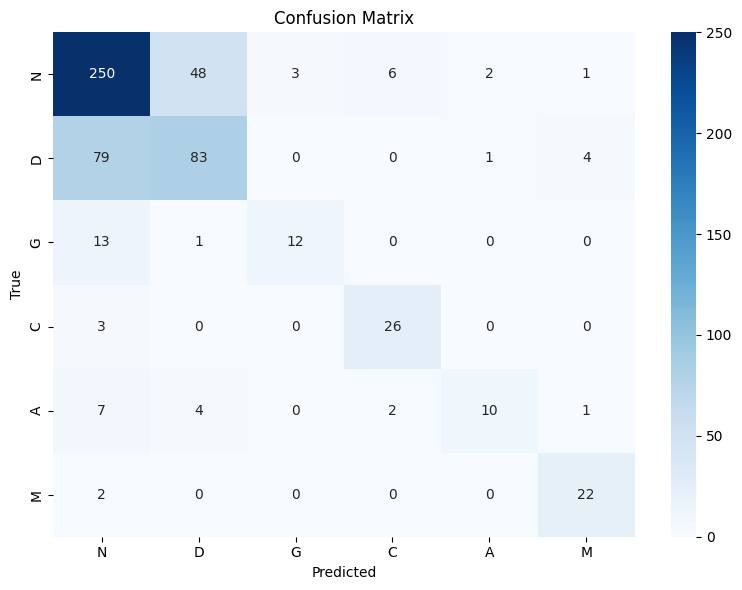

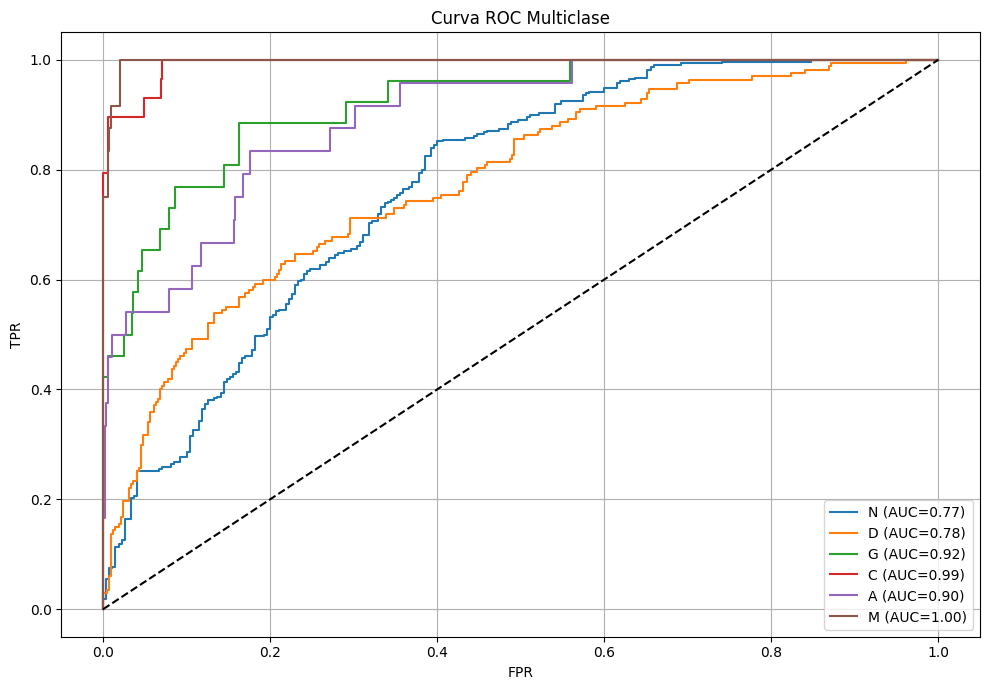

In [1]:
### Modelo 1 sin mixup y cutmix  mejor modelo###

import os, sys, cv2, numpy as np, pandas as pd, torch
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import argparse  
from PIL import Image
from torchvision import transforms

# CONFIG
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 80
LABEL_SMOOTH = 0.1
ENSEMBLE_W = 0.7
LABELS = ['N', 'D', 'G', 'C', 'A', 'M']
LABEL_MAP = {c: i for i, c in enumerate(LABELS)}

# === CARGA DE DATOS ===
train_df = pd.read_csv("C:/Users/34629/TFG/train_GAN.csv")
val_df = pd.read_csv("C:/Users/34629/TFG/val_GAN.csv")
train_df['label'] = train_df['class_label'].map(LABEL_MAP)
val_df['label'] = val_df['class_label'].map(LABEL_MAP)

train_paths = train_df['Image_Path'].tolist()
val_paths = val_df['Image_Path'].tolist()
train_labels = train_df['label'].tolist()
val_labels = val_df['label'].tolist()

# === IMPORTAR RETFOUND ===
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

rf_train_path = "C:/Users/34629/Downloads/X_rf_train_GAN.npy"
rf_val_path = "C:/Users/34629/Downloads/X_rf_val_GAN.npy"
eff_train_path = "C:/Users/34629/Downloads/X_eff_train_GAN.npy"
eff_val_path = "C:/Users/34629/Downloads/X_eff_val_GAN.npy"
y_train_path = "C:/Users/34629/Downloads/y_train_GAN.npy"
y_val_path = "C:/Users/34629/Downloads/y_val_GAN.npy"

# Funciones de extracción
def extract_retfound_features(paths, weights_path):
    model = RETFound_mae(global_pool=True, img_size=IMG_SIZE)
    torch.serialization.add_safe_globals([argparse.Namespace])
    ckpt = torch.load(weights_path, map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None)
    sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd)
    model.load_state_dict(sd, strict=False)
    model.eval()
    feats = []
    for p in tqdm(paths, desc="RETFound feats"):
        img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE)) / 255.0
        x = torch.from_numpy(img.astype('float32')).permute(2, 0, 1).unsqueeze(0)
        with torch.no_grad():
            f = model.forward_features(x).cpu().numpy().squeeze()
        feats.append(f)
    return np.stack(feats)

from tensorflow.keras.applications import EfficientNetB3, efficientnet
eff_model = EfficientNetB3(include_top=False, pooling='avg', weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

def extract_eff_features(paths):
    feats = []
    for p in tqdm(paths, desc="EffNet feats"):
        img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE))
        x = efficientnet.preprocess_input(img.astype('float32'))
        feats.append(eff_model(np.expand_dims(x, 0), training=False).numpy().squeeze())
    return np.stack(feats)

# === CARGAR O EXTRAER CARACTERÍSTICAS ===
if all(os.path.exists(p) for p in [rf_train_path, rf_val_path, eff_train_path, eff_val_path, y_train_path, y_val_path]):
    X1_tr = np.load(rf_train_path)
    X2_tr = np.load(eff_train_path)
    y_tr = np.load(y_train_path)
    X1_vl = np.load(rf_val_path)
    X2_vl = np.load(eff_val_path)
    y_vl = np.load(y_val_path)
    print("✅ Características cargadas de disco.")
else:
    print("⚙️ Extrayendo características...")
    X1_tr = extract_retfound_features(train_paths, "C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
    X2_tr = extract_eff_features(train_paths)
    y_tr = np.array(train_labels)
    X1_vl = extract_retfound_features(val_paths, "C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
    X2_vl = extract_eff_features(val_paths)
    y_vl = np.array(val_labels)
    np.save(rf_train_path, X1_tr)
    np.save(eff_train_path, X2_tr)
    np.save(y_train_path, y_tr)
    np.save(rf_val_path, X1_vl)
    np.save(eff_val_path, X2_vl)
    np.save(y_val_path, y_vl)

# === MODELOS ===
y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))
y_tr_cat = y_tr_cat * (1 - LABEL_SMOOTH) + LABEL_SMOOTH / len(LABELS)

inp1 = Input((X1_tr.shape[1],))
x = Dense(1024)(inp1)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512, activation='relu')(inp2)
y_ = Dropout(0.4)(y_)
out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False)
for model in [m1, m2]:
    model.compile(optimizer=Adam(1e-4), loss=loss_fn,
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro', name='f1')])

m1.fit(X1_tr, y_tr_cat, validation_data=(X1_vl, y_vl_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
m2.fit(X2_tr, y_tr_cat, validation_data=(X2_vl, y_vl_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# === EVALUACIÓN ===
p1 = m1.predict(X1_vl)
p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2

# Ajuste de umbrales
THRESH = np.ones(len(LABELS)) * 0.5
for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_vl == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(int(np.argmax(row)))
y_pred = np.array(y_pred)

print("\n📋 Classification Report:")
print(classification_report(y_vl, y_pred, target_names=LABELS))

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_vl, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === CURVA ROC MULTICLASE ===
y_vl_bin = label_binarize(y_vl, classes=np.arange(len(LABELS)))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_vl_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i, label in enumerate(LABELS):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC Multiclase")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# === GRAD-CAM ===
df_res = pd.DataFrame({'img': val_paths, 'true': y_vl, 'pred': y_pred})
df_res['correct'] = df_res['true'] == df_res['pred']

# Función Grad-CAM

def generar_gradcam(img_path, nombre_archivo):

    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace]) 
    
    model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd)
    model.load_state_dict(sd, strict=False); model.eval()

    activations = {}
    def hook_fn(module, input, output): activations['value'] = output
    model.blocks[11].register_forward_hook(hook_fn)

    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)

    with torch.no_grad(): logits = model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14, 14)
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * (cam - cam.min()) / (cam.max() - cam.min()))
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    cv2.imwrite(nombre_archivo, cv2.cvtColor(np.uint8(superpuesta), cv2.COLOR_RGB2BGR))

bien = df_res[df_res['correct']].iloc[0]
generar_gradcam(bien['img'], f"gradcam_GAN_bien_{LABELS[bien['true']]}.png")
mal = df_res[~df_res['correct']].iloc[0]
generar_gradcam(mal['img'], f"gradcam_GAN_mal_{LABELS[mal['true']]}_pred{LABELS[mal['pred']]}.png")


In [3]:
### Modelo con mixup###


import os, sys, cv2, numpy as np, pandas as pd, torch
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
import argparse

# CONFIG
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 80
LABELS = ['N', 'D', 'G', 'C', 'A', 'M']
LABEL_MAP = {c: i for i, c in enumerate(LABELS)}
ENSEMBLE_W = 0.7

# Rutas a los datos
rf_train_path = "C:/Users/34629/Downloads/X_rf_train_GAN.npy"
rf_val_path   = "C:/Users/34629/Downloads/X_rf_val_GAN.npy"
eff_train_path = "C:/Users/34629/Downloads/X_eff_train_GAN.npy"
eff_val_path   = "C:/Users/34629/Downloads/X_eff_val_GAN.npy"
y_train_path = "C:/Users/34629/Downloads/y_train_GAN.npy"
y_val_path   = "C:/Users/34629/Downloads/y_val_GAN.npy"
val_csv_path = "C:/Users/34629/TFG/val_GAN.csv"

# Cargar los datos
X1_tr = np.load(rf_train_path)
X2_tr = np.load(eff_train_path)
y_tr = np.load(y_train_path)
X1_vl = np.load(rf_val_path)
X2_vl = np.load(eff_val_path)
y_vl = np.load(y_val_path)
paths_val = pd.read_csv(val_csv_path)["Image_Path"].tolist()

# One-hot
y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))

# Mixup
lam = np.random.beta(0.4, 0.4)
idx = np.random.permutation(len(X1_tr))
X1_tr = lam * X1_tr + (1 - lam) * X1_tr[idx]
X2_tr = lam * X2_tr + (1 - lam) * X2_tr[idx]
y_tr_cat = lam * y_tr_cat + (1 - lam) * y_tr_cat[idx]

# Modelos
inp1 = Input((X1_tr.shape[1],))
x = Dense(1024)(inp1); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x); x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x); out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512, activation='relu')(inp2); y_ = Dropout(0.4)(y_)
out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False)
for model in [m1, m2]:
    model.compile(optimizer=Adam(1e-4), loss=loss_fn,
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro', name='f1')])

m1.fit(X1_tr, y_tr_cat, validation_data=(X1_vl, y_vl_cat),
       epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
m2.fit(X2_tr, y_tr_cat, validation_data=(X2_vl, y_vl_cat),
       epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# Predicciones
p1 = m1.predict(X1_vl); p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2

# Umbrales
THRESH = np.ones(len(LABELS)) * 0.5
y_true = y_vl
for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_true == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

# Predicción final
y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(int(np.argmax(row)))
y_pred = np.array(y_pred)

# Reporte
print(classification_report(y_true, y_pred, target_names=LABELS))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title("Matriz de Confusi\u00f3n")
plt.tight_layout()
plt.savefig("matriz_confusion_modelo_GAN_mixup.png")
plt.close()

# ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(LABELS)))
plt.figure(figsize=(10, 8))
for i in range(len(LABELS)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{LABELS[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--'); plt.legend()
plt.title("Curvas ROC por clase")
plt.tight_layout()
plt.savefig("curva_ROC_modelo_GAN_mixup.png")
plt.close()

# Grad-CAM
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

def generar_gradcam(img_path, nombre_archivo):
    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace])
    ret_model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu', weights_only=False)
    sd = ckpt['model']; sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(ret_model, sd)
    ret_model.load_state_dict(sd, strict=False)
    ret_model.eval()
    activations = {}
    ret_model.blocks[11].register_forward_hook(lambda m, i, o: activations.update({'value': o}))
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad(): ret_model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14, 14)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    cv2.imwrite(nombre_archivo, cv2.cvtColor(np.uint8(superpuesta), cv2.COLOR_RGB2BGR))

# Generar para una imagen bien y mal clasificada
df_res = pd.DataFrame({'img': paths_val[:len(y_true)], 'true': [LABELS[i] for i in y_true], 'pred': [LABELS[i] for i in y_pred]})
df_res['correcto'] = df_res['true'] == df_res['pred']
bien = df_res[df_res['correcto']].iloc[0]
mal = df_res[~df_res['correcto']].iloc[0]
generar_gradcam(bien['img'], f"gradcam_GAN_correcto_{bien['pred']}.png")
generar_gradcam(mal['img'], f"gradcam_GAN_error_{mal['true']}_pred{mal['pred']}.png")


Epoch 1/80
762/762 - 49s - loss: 0.1307 - accuracy: 0.7621 - f1: 0.7147 - val_loss: 0.1888 - val_accuracy: 0.5483 - val_f1: 0.3656 - 49s/epoch - 64ms/step
Epoch 2/80
762/762 - 41s - loss: 0.0938 - accuracy: 0.8013 - f1: 0.7503 - val_loss: 0.1789 - val_accuracy: 0.5879 - val_f1: 0.3837 - 41s/epoch - 54ms/step
Epoch 3/80
762/762 - 40s - loss: 0.0867 - accuracy: 0.8138 - f1: 0.7579 - val_loss: 0.1774 - val_accuracy: 0.5983 - val_f1: 0.4420 - 40s/epoch - 53ms/step
Epoch 4/80
762/762 - 40s - loss: 0.0850 - accuracy: 0.8157 - f1: 0.7602 - val_loss: 0.1707 - val_accuracy: 0.6000 - val_f1: 0.3962 - 40s/epoch - 53ms/step
Epoch 5/80
762/762 - 39s - loss: 0.0827 - accuracy: 0.8230 - f1: 0.7664 - val_loss: 0.1726 - val_accuracy: 0.6017 - val_f1: 0.4306 - 39s/epoch - 51ms/step
Epoch 6/80
762/762 - 32s - loss: 0.0807 - accuracy: 0.8237 - f1: 0.7654 - val_loss: 0.1700 - val_accuracy: 0.6000 - val_f1: 0.4204 - 32s/epoch - 43ms/step
Epoch 7/80
762/762 - 33s - loss: 0.0792 - accuracy: 0.8267 - f1: 0.767

In [2]:
### Modelo GAN con CutMix ###

import os, sys, cv2, numpy as np, pandas as pd, torch
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
import argparse

# CutMix Generator
class CutMixGenerator(Sequence):
    def __init__(self, x, y, batch_size, alpha=1.0):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.alpha = alpha
        self.n = len(x)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, idx):
        indices = np.random.permutation(self.n)
        x1 = self.x[indices[:self.batch_size]]
        y1 = self.y[indices[:self.batch_size]]
        x2 = self.x[indices[self.batch_size:2*self.batch_size]]
        y2 = self.y[indices[self.batch_size:2*self.batch_size]]

        lam = np.random.beta(self.alpha, self.alpha)
        x = lam * x1 + (1 - lam) * x2
        y = lam * y1 + (1 - lam) * y2
        return x, y

# Configuración
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 80
LABELS = ['N', 'D', 'G', 'C', 'A', 'M']
LABEL_MAP = {c: i for i, c in enumerate(LABELS)}
ENSEMBLE_W = 0.7

# Cargar características ya extraídas
X1_tr = np.load("C:/Users/34629/Downloads/X_rf_train_GAN.npy")
X2_tr = np.load("C:/Users/34629/Downloads/X_eff_train_GAN.npy")
y_tr  = np.load("C:/Users/34629/Downloads/y_train_GAN.npy")
X1_vl = np.load("C:/Users/34629/Downloads/X_rf_val_GAN.npy")
X2_vl = np.load("C:/Users/34629/Downloads/X_eff_val_GAN.npy")
y_vl  = np.load("C:/Users/34629/Downloads/y_val_GAN.npy")
paths_val = pd.read_csv("C:/Users/34629/TFG/val_GAN.csv")["Image_Path"].tolist()

# Codificación one-hot
y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))

# Modelos
inp1 = Input((X1_tr.shape[1],))
x = Dense(1024)(inp1)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512, activation='relu')(inp2)
y_ = Dropout(0.4)(y_)
out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

# Compilar
loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False)
for model in [m1, m2]:
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_fn,
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro', name='f1')])

# Callbacks
cb_rf = [EarlyStopping('val_f1', mode='max', patience=10, restore_best_weights=True),
         ModelCheckpoint("Clas_GAN_rf_cutmix_manual.h5", monitor='val_f1', save_best_only=True)]
cb_eff = [EarlyStopping('val_f1', mode='max', patience=10, restore_best_weights=True),
          ModelCheckpoint("Clas_GAN_eff_cutmix_manual.h5", monitor='val_f1', save_best_only=True)]

# Generadores CutMix
gen_rf = CutMixGenerator(X1_tr, y_tr_cat, BATCH_SIZE, alpha=1.0)
gen_eff = CutMixGenerator(X2_tr, y_tr_cat, BATCH_SIZE, alpha=1.0)

# Entrenamiento
m1.fit(gen_rf, validation_data=(X1_vl, y_vl_cat), epochs=EPOCHS, callbacks=cb_rf, verbose=2)
m2.fit(gen_eff, validation_data=(X2_vl, y_vl_cat), epochs=EPOCHS, callbacks=cb_eff, verbose=2)

# Predicción y Ensemble
p1 = m1.predict(X1_vl)
p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2

# Ajuste de umbrales
THRESH = np.ones(len(LABELS)) * 0.5
y_true = y_vl
y_vl_bin = label_binarize(y_true, classes=list(range(len(LABELS))))
for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_true == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

# Decodificación
y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(int(np.argmax(row)))
y_pred = np.array(y_pred)

# Reporte
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=LABELS))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.savefig("matriz_confusion_modelo_GAN_cutmix.png")
plt.close()

# Curvas ROC
plt.figure(figsize=(10, 7))
for i, label in enumerate(LABELS):
    fpr, tpr, _ = roc_curve(y_vl_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("curva_ROC_modelo_GAN_cutmix.png")
plt.close()

# Grad-CAM
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

def generar_gradcam(img_path, nombre_archivo):
    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace])
    ret_model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None)
    sd.pop('head.bias', None)
    interpolate_pos_embed(ret_model, sd)
    ret_model.load_state_dict(sd, strict=False)
    ret_model.eval()

    activations = {}
    def hook_fn(module, input, output):
        activations['value'] = output
    ret_model.blocks[11].register_forward_hook(hook_fn)

    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad():
        logits = ret_model(x)
    act = activations['value'].squeeze(0).numpy()   # [tokens, dim]
    grid_size = int(np.sqrt(act.shape[0] - 1))      # por ejemplo, 64 => sqrt(63) ≈ 8
    cam = act[1:].mean(axis=1).reshape(grid_size, grid_size)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    superpuesta = np.uint8(superpuesta)
    cv2.imwrite(nombre_archivo, cv2.cvtColor(superpuesta, cv2.COLOR_RGB2BGR))

# Generar Grad-CAM para una imagen correcta y una incorrecta
df_res = pd.DataFrame({
    'img': paths_val[:len(y_true)],
    'true': [LABELS[i] for i in y_true],
    'pred': [LABELS[i] for i in y_pred]
})
df_res['correcto'] = df_res['true'] == df_res['pred']

bien = df_res[df_res['correcto']].iloc[0]
generar_gradcam(bien['img'], f"gradcam_GAN_correcto_{bien['pred']}.png")

mal = df_res[~df_res['correcto']].iloc[0]
generar_gradcam(mal['img'], f"gradcam_GAN_error_{mal['true']}_pred{mal['pred']}.png")


Epoch 1/80


c:\Users\34629\TFG\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


761/761 - 67s - loss: 0.1824 - accuracy: 0.6988 - f1: 0.5967 - val_loss: 0.1934 - val_accuracy: 0.5759 - val_f1: 0.4115 - 67s/epoch - 88ms/step
Epoch 2/80
761/761 - 42s - loss: 0.1452 - accuracy: 0.7453 - f1: 0.6297 - val_loss: 0.1825 - val_accuracy: 0.5914 - val_f1: 0.3915 - 42s/epoch - 55ms/step
Epoch 3/80
761/761 - 40s - loss: 0.1374 - accuracy: 0.7557 - f1: 0.6380 - val_loss: 0.1785 - val_accuracy: 0.5862 - val_f1: 0.4053 - 40s/epoch - 53ms/step
Epoch 4/80
761/761 - 32s - loss: 0.1330 - accuracy: 0.7694 - f1: 0.6425 - val_loss: 0.1897 - val_accuracy: 0.5224 - val_f1: 0.4125 - 32s/epoch - 41ms/step
Epoch 5/80
761/761 - 36s - loss: 0.1304 - accuracy: 0.7712 - f1: 0.6447 - val_loss: 0.1770 - val_accuracy: 0.6069 - val_f1: 0.4328 - 36s/epoch - 47ms/step
Epoch 6/80
761/761 - 37s - loss: 0.1289 - accuracy: 0.7708 - f1: 0.6465 - val_loss: 0.1734 - val_accuracy: 0.6034 - val_f1: 0.4314 - 37s/epoch - 49ms/step
Epoch 7/80
761/761 - 36s - loss: 0.1272 - accuracy: 0.7773 - f1: 0.6508 - val_los

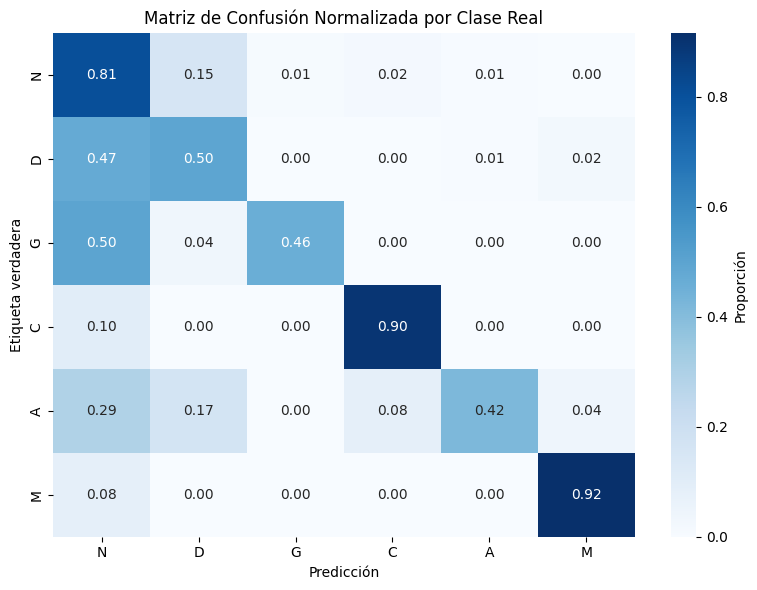

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz extraída visualmente de la imagen
conf_matrix = np.array([
    [250, 48,  3, 6, 2, 1],
    [79,  83,  0, 0, 1, 4],
    [13, 1,  12, 0, 0, 0],
    [3,  0,   0, 26, 0, 0],
    [7,  4,   0, 2, 10, 1],
    [2,  0,   0, 0, 0, 22]
])

labels = ['N', 'D', 'G', 'C', 'A', 'M']

# Normalizar por filas (clases reales)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_norm = conf_matrix / row_sums

# Graficar matriz de confusión normalizada
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proporción'})
plt.title("Matriz de Confusión Normalizada por Clase Real")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.tight_layout()
plt.show()
